In [ ]:
# Credenciales CDSAPI (en Colab sobrescribir si es necesario)
!echo "url: https://cds.climate.copernicus.eu/api" >> ~/.cdsapirc
!echo "key: 8ed01691-cb79-45f4-b426-815241203696" >> ~/.cdsapirc

0) Encabezado y parámetros

Define fecha objetivo y región (Chile por defecto).

Define baseline (recomendado 1991–2020).

Instala librerías y configura Dask.

In [ ]:
# ==== 0) Parámetros y entorno ====
!pip -q install cdsapi xarray netCDF4 dask[complete] numpy pandas scipy matplotlib

import os, numpy as np, xarray as xr, pandas as pd, dask
from dask.diagnostics import ProgressBar
ProgressBar().register()

# ---- Parámetros del análisis ----
TARGET_DATE = "2022-09-28"                   # día objetivo
BASELINE    = ("2020-01-01", "2024-12-31")   # periodo de estandarización mensual
YEAR_TARGET = TARGET_DATE[:4]
MONTH_TARGET= TARGET_DATE[:7]                # 'YYYY-MM' para seleccionar el mes

# Región (Chile ampliado). Coord ERA5: lat N→S, lon -180..180 ó 0..360 (CDS usa -180..180)
AREA = [ -15, -90, -60, -65 ]  # [N, W, S, E] → ajusta si quieres (menos área = menos RAM/IO)



# Dask: límites de chunk y directorio temporal
import dask.config as dc
dc.set({
    "array.chunk-size": "128MiB",
    "temporary-directory": "/tmp",
    "optimization.fuse.active": True
})




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.3 MB/s eta 0:00:00


In [ ]:
import os, netCDF4 as nc

def _valid_nc(path, min_bytes=10_000):
    if not os.path.exists(path): return False
    if os.path.getsize(path) < min_bytes: return False
    try:
        nc.Dataset(path).close()
        return True
    except Exception:
        return False

for f in ["era5_mo_t2m.nc", "era5land_mo_tp_e_pev.nc"]:
    if os.path.exists(f) and not _valid_nc(f):
        print(f"[CLEAN] removing invalid file → {f}")
        try: os.remove(f)
        except Exception as e: print("remove failed:", e)


In [ ]:
# --- Celda 3.1: FIX de archivos (gzip/zip/tar/html) + verificación NetCDF ---
import os, gzip, zipfile, tarfile, shutil, netCDF4 as nc, pathlib

def _sniff(path):
    p = pathlib.Path(path)
    #if not p.exists() or p.stat().st_size == 0: return "empty"
    head = open(path, "rb").read(512)
    if head.startswith(b"\x1f\x8b"): return "gzip"
    if head.startswith(b"PK\x03\x04"): return "zip"
    if head.startswith(b"\x89HDF\r\n\x1a\n"): return "netcdf4"
    if head.startswith(b"CDF"): return "netcdf3"
    if head.startswith(b"GRIB"): return "grib"
    if head.lstrip().lower().startswith(b"<html") or head.lstrip().lower().startswith(b"<!doctype html"):
        return "html"
    if b"ustar" in head[257:265]: return "tar"
    return "unknown"

def repair_era5_file_inplace(path: str) -> str:
    kind = _sniff(path); print(f"[repair] {path} → {kind}")
    if kind in {"netcdf3","netcdf4"}:
        nc.Dataset(path).close(); return path
    if kind == "empty": raise OSError("Archivo vacío, reintenta descarga.")
    if kind == "html": raise OSError("El archivo es HTML (error CDS). Revisa key/parámetros.")
    if kind == "grib": raise OSError("Archivo GRIB: pide 'format: netcdf' o abre con engine='cfgrib'.")

    tmp = path + ".tmp.nc"
    if kind == "gzip":
        with gzip.open(path, "rb") as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "zip":
        with zipfile.ZipFile(path) as zf:
            members = [n for n in zf.namelist() if n.lower().endswith(".nc")]
            if not members: raise OSError("ZIP sin .nc")
            with zf.open(members[0]) as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "tar":
        with tarfile.open(path) as tf:
            members = [m for m in tf.getmembers() if m.isfile() and m.name.lower().endswith(".nc")]
            if not members: raise OSError("TAR sin .nc")
            with tf.extractfile(members[0]) as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "unknown":
        try:
            nc.Dataset(path).close(); return path
        except Exception as e:
            raise OSError(f"Formato desconocido y no abre: {e}")

    nc.Dataset(tmp).close()
    bak = path + ".bak"
    if os.path.exists(bak): os.remove(bak)
    os.rename(path, bak); os.replace(tmp, path)
    print("[repair] Reparado ✓ (backup .bak)")
    return path


1) Descarga de datos (CDSAPI, sólo lo necesario)

ERA5 monthly (single levels): 2m_temperature (T2M) → STI.

ERA5-Land monthly: total_precipitation (tp), total_evaporation (e), potential_evaporation (pev) → SEPI/SETI.

Descarga baseline (1991–2020) + año objetivo (para tener el mes del día).

In [ ]:
# ==== 1) Descarga ERA5/ERA5-Land mensual ====
import cdsapi, pathlib
c = cdsapi.Client()

def dl_era5_monthly_t2m(years, out_nc, area=None):
    if not pathlib.Path(out_nc).exists():
        req = {
            "product_type": "monthly_averaged_reanalysis",
            "variable": ["2m_temperature"],
            "year": years, "month": [f"{m:02d}" for m in range(1,13)],
            "time": "00:00", "format": "netcdf"
        }
        if area: req["area"] = area
        c.retrieve("reanalysis-era5-single-levels-monthly-means", req, out_nc)
    print("OK:", out_nc)

def dl_era5land_monthly_tp_e_pev(years, out_nc, area=None):
    if not pathlib.Path(out_nc).exists():
        req = {
            "product_type": "monthly_averaged_reanalysis",
            "variable": ["total_precipitation","total_evaporation","potential_evaporation"],
            "year": years, "month": [f"{m:02d}" for m in range(1,13)],
            "time": "00:00", "format": "netcdf"
        }
        if area: req["area"] = area
        c.retrieve("reanalysis-era5-land-monthly-means", req, out_nc)
    print("OK:", out_nc)



In [ ]:
#robust
import logging, cdsapi, json, os
logging.basicConfig(level=logging.INFO)
c = cdsapi.Client(timeout=3600, retry_max=3, debug=True)

def dl_era5_mo_t2m(years, out_nc, area=None):
    req = {
        "product_type":"monthly_averaged_reanalysis",
        "variable":["2m_temperature"],
        "year": years, "month":[f"{m:02d}" for m in range(1,13)],
        "time":"00:00", "format":"netcdf"
    }
    if area: req["area"] = area
    r = c.retrieve("reanalysis-era5-single-levels-monthly-means", req)
    print("REPLY:", json.dumps(r.reply, indent=2)[:1000])
    r.download(out_nc)
    print("[OK] descargado:", out_nc, os.path.getsize(out_nc), "bytes")

def dl_era5land_mo_tp_e_pev(years, out_nc, area=None):
    req = {
        "product_type":"monthly_averaged_reanalysis",
        "variable":["total_precipitation","total_evaporation","potential_evaporation"],
        "year": years, "month":[f"{m:02d}" for m in range(1,13)],
        "time":"00:00", "format":"netcdf"
    }
    if area: req["area"] = area
    r = c.retrieve("reanalysis-era5-land-monthly-means", req)
    print("REPLY:", json.dumps(r.reply, indent=2)[:1000])
    r.download(out_nc)
    print("[OK] descargado:", out_nc, os.path.getsize(out_nc), "bytes")


2025-10-21 15:30:20,127 DEBUG GET https://cds.climate.copernicus.eu/api/catalogue/v1/messages
DEBUG:ecmwf.datastores.legacy_client:GET https://cds.climate.copernicus.eu/api/catalogue/v1/messages
2025-10-21 15:30:26,400 DEBUG REPLY {"messages":[]}
DEBUG:ecmwf.datastores.legacy_client:REPLY {"messages":[]}
2025-10-21 15:30:26,401 DEBUG CDSAPI {'url': 'https://cds.climate.copernicus.eu/api', 'key': '8ed01691-cb79-45f4-b426-815241203696', 'quiet': False, 'verify': True, 'timeout': 3600, 'progress': True, 'sleep_max': 120, 'retry_max': 3, 'delete': False, 'datastores_version': '0.4.0'}
DEBUG:ecmwf.datastores.legacy_client:CDSAPI {'url': 'https://cds.climate.copernicus.eu/api', 'key': '8ed01691-cb79-45f4-b426-815241203696', 'quiet': False, 'verify': True, 'timeout': 3600, 'progress': True, 'sleep_max': 120, 'retry_max': 3, 'delete': False, 'datastores_version': '0.4.0'}


In [ ]:
years_base = [str(y) for y in range(int(BASELINE[0][:4]), int(BASELINE[1][:4])+1)]
years_all  = sorted(set(years_base + [YEAR_TARGET]))

dl_era5_monthly_t2m(years_all,  "era5_mo_t2m.nc", area=AREA)
dl_era5land_monthly_tp_e_pev(years_all, "era5land_mo_tp_e_pev.nc", area=AREA)


2025-10-21 15:30:26,410 DEBUG GET https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-single-levels-monthly-means
DEBUG:ecmwf.datastores.legacy_client:GET https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-single-levels-monthly-means
2025-10-21 15:30:26,814 DEBUG REPLY {"title":"ERA5 monthly averaged data on single levels from 1940 to present","description":"ERA5 is the fifth generation ECMWF reanalysis for the global climate and weather for the past 8 decades.\nData is available from 1940 onwards.\nERA5 replaces the ERA-Interim reanalysis.\nReanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. This principle, called data assimilation, is based on the method used by numerical weather prediction centres, where every so many hours (12 hours at ECMWF) a previous forecast is combined with newly available observations in an optimal way to produce a new

d85159adf2345b2b0db00afe3e4c2ccf.nc:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

2025-10-21 15:30:53,485 DEBUG GET https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-land-monthly-means
DEBUG:ecmwf.datastores.legacy_client:GET https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-land-monthly-means


OK: era5_mo_t2m.nc


2025-10-21 15:30:53,689 DEBUG REPLY {"title":"ERA5-Land monthly averaged data from 1950 to present","description":"ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5. ERA5-Land has been produced by replaying the land component of the ECMWF ERA5 climate reanalysis. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. Reanalysis produces data that goes several decades back in time, providing an accurate description of the climate of the past.\nERA5-Land provides a consistent view of the water and energy cycles at surface level during several decades.\nIt contains a detailed record from 1950 onwards, with a temporal resolution of 1 hour. The native spatial resolution of the ERA5-Land reanalysis dataset is 9km on a reduced Gaussian grid (TCo1279). The data in the CDS has been regridded to a

7af9bdb2a0dad62ec00c0809f2c47347.zip:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

OK: era5land_mo_tp_e_pev.nc


In [ ]:
!ls -hs

total 19M
 18M era5land_mo_tp_e_pev.nc  1.6M era5_mo_t2m.nc  4.0K sample_data


In [ ]:
_ = repair_era5_file_inplace("era5land_mo_tp_e_pev.nc")


[repair] era5land_mo_tp_e_pev.nc → zip
[repair] Reparado ✓ (backup .bak)


2) Carga segura y armonización (lat ↓, lon ordenada), float32 + chunks

Carga con chunks={"time": 24} (bajo RAM).

Convierte unidades a mm/mes y K.

Nota: los productos monthly means suelen venir en metros; tratamos como mm/mes usando factor 1000 (consistente con pipelines previos).

In [ ]:
# ==== 2) Cargar datasets y armonizar ====
def harmonize_era5(ds: xr.Dataset) -> xr.Dataset:
    out = ds
    # normalizar nombres por si acaso
    rn = {}
    if "valid_time" in out.coords and "time" not in out.coords: rn["valid_time"] = "time"
    if rn: out = out.rename(rn)
    # lat descendente
    if "latitude" in out and float(out.latitude.values[0]) < float(out.latitude.values[-1]):
        out = out.reindex(latitude=out.latitude[::-1])
    # lon 0..360 opcional; aquí dejamos en -180..180 como viene del CDS
    out = out.sortby("longitude")
    return out

_ = repair_era5_file_inplace("era5land_mo_tp_e_pev.nc")
mo_t2m  = xr.open_dataset("era5_mo_t2m.nc", engine="netcdf4",
                          chunks={"time": 24}).pipe(harmonize_era5)
mo_land = xr.open_dataset("era5land_mo_tp_e_pev.nc", engine="netcdf4",
                          chunks={"time": 24}).pipe(harmonize_era5)

# Cast a float32 (lazy)
for v in mo_t2m.data_vars:  mo_t2m[v]  = mo_t2m[v].astype("float32")
for v in mo_land.data_vars: mo_land[v] = mo_land[v].astype("float32")

# DataArrays con unidades homogéneas
t2m = mo_t2m["t2m"]                       # K (mensual)
tp  = mo_land["tp"]  * np.float32(1000.0) # mm (mensual)
e   = mo_land["e"]   * np.float32(-1000.) # ET real positiva mm (invertimos signo)
pev = mo_land["pev"] * np.float32(1000.0) # PET mm (mensual)

# Subconjuntos de baseline y año objetivo
t2m_base = t2m.sel(time=slice(*BASELINE))
tp_base, e_base, pev_base = (tp.sel(time=slice(*BASELINE)),
                             e.sel(time=slice(*BASELINE)),
                             pev.sel(time=slice(*BASELINE)))
t2m_year = t2m.sel(time=slice(f"{YEAR_TARGET}-01-01", f"{YEAR_TARGET}-12-31"))
tp_year, e_year, pev_year = (tp.sel(time=f"{YEAR_TARGET}"),
                             e.sel(time=f"{YEAR_TARGET}"),
                             pev.sel(time=f"{YEAR_TARGET}"))
print("Shapes →", t2m_base.shape, tp_base.shape, "target year:", t2m_year.shape)


[repair] era5land_mo_tp_e_pev.nc → netcdf4
Shapes → (60, 181, 101) (60, 451, 251) target year: (12, 181, 101)


## 3) Utilidades de índices (clean & reutilizables)

Estandarización empírica por mes (robusta).

Pᵉ (EWMA) para SEPI.

Rolling k-meses.

In [ ]:
# ==== 3) Helpers de índices ====
from scipy import stats

def rolling_months(da: xr.DataArray, k: int, how: str = "sum") -> xr.DataArray:
    if k < 1: raise ValueError("k>=1")
    roll = da.rolling(time=k, min_periods=k)
    return roll.sum() if how == "sum" else roll.mean()

def ewma_effective_precip(tp_mm_mon: xr.DataArray, alpha: float = 0.85) -> xr.DataArray:
    import pandas as pd
    def _ewma(x, a):
        s = pd.Series(x)
        return s.ewm(alpha=(1-a), adjust=False).mean().values
    pe = xr.apply_ufunc(_ewma, tp_mm_mon, alpha,
                        input_core_dims=[["time"], []],
                        output_core_dims=[["time"]],
                        vectorize=True, dask="allowed", output_dtypes=[np.float32])
    pe.name = "pe_mm"; pe.attrs.update(units="mm/month")
    return pe

def standardize_empirical_by_month(da_mon: xr.DataArray,
                                   baseline: tuple[str,str]) -> xr.DataArray:
    def _emp(x):
        r = stats.rankdata(x, method="average")
        u = r / (len(x) + 1.0)
        return stats.norm.ppf(u)
    _ = da_mon.sel(time=slice(*baseline))
    z = xr.apply_ufunc(_emp, da_mon.groupby("time.month"),
                       input_core_dims=[["time"]],
                       output_core_dims=[["time"]],
                       vectorize=True, dask="allowed")
    z.attrs.update(units="sigma")
    return z


## 4) Cálculo de STI (mensual) para el mes del día objetivo

STI = (T2M − μ_mes) / σ_mes (μ, σ de baseline por mes).

In [ ]:
# ==== 4) STI mensual (mes del día objetivo) ====
mu_t2m = t2m_base.groupby("time.month").mean("time")
sd_t2m = t2m_base.groupby("time.month").std("time")
month_idx = int(MONTH_TARGET[-2:])

sti_month = ((t2m.groupby("time.month") - mu_t2m) / sd_t2m).sel(time=MONTH_TARGET)
sti_month.name = "STI"
sti_month.attrs.update(long_name="Standardized Temperature Index (monthly)")

print("STI listo para", MONTH_TARGET, "→", tuple(sti_month.shape))


STI listo para 2022-09 → (1, 181, 101, 12)


/usr/local/lib/python3.12/dist-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


## 5) Cálculo de SEPI (Pᵉ + estandarización) en k = 1,3,6,12

Pᵉ con α=0.85 (ajustable).

Estandarización empírica por mes.

In [ ]:
# ==== 3) Helpers de índices (parche robusto) ====
import numpy as np, xarray as xr
from scipy import stats

def rolling_months(da: xr.DataArray, k: int, how: str = "sum") -> xr.DataArray:
    if k < 1: raise ValueError("k>=1")
    roll = da.rolling(time=k, min_periods=k)
    return roll.sum() if how == "sum" else roll.mean()

def _ewma_1d(x: np.ndarray, alpha: float) -> np.ndarray:
    """
    EWMA 1-D NaN-safe: P^e(t) = α P^e(t-1) + (1-α) P(t)
    - Si el primer valor es NaN, busca el primer finito.
    - Si hay NaN en medio, propaga el último P^e válido.
    """
    x = x.astype(np.float32, copy=False)
    y = np.full_like(x, np.nan, dtype=np.float32)
    n = x.shape[0]
    # inicialización: primer valor finito
    i0 = np.argmax(np.isfinite(x))
    if not np.isfinite(x[i0]):  # todo NaN
        return y
    y[i0] = x[i0]
    for i in range(i0+1, n):
        xi = x[i]
        if np.isfinite(xi):
            y[i] = alpha * y[i-1] + (1.0 - alpha) * xi
        else:
            y[i] = y[i-1]  # propaga último valor válido
    return y

def ewma_effective_precip(tp_mm_mon: xr.DataArray, alpha: float = 0.85) -> xr.DataArray:
    """
    EWMA sobre la dimensión 'time' usando NumPy (no pandas).
    Vectoriza sobre (lat, lon). Dask-parallelized.
    """
    # Asegura orden con 'time' como core dim
    tp_mm_mon = tp_mm_mon.transpose("time", "latitude", "longitude")
    pe = xr.apply_ufunc(
        _ewma_1d, tp_mm_mon, alpha,
        input_core_dims=[["time"], []],
        output_core_dims=[["time"]],
        vectorize=True, dask="parallelized",
        output_dtypes=[np.float32],
        dask_gufunc_kwargs={"allow_rechunk": True,
                            "output_sizes": {"time": tp_mm_mon.sizes["time"]}}
    )
    pe.name = "pe_mm"; pe.attrs.update(units="mm/month")
    return pe

def _empirical_z_against_ref(x: np.ndarray, ref: np.ndarray) -> np.ndarray:
    """
    Z empírico de x contra CDF de ref (ambos 1-D en 'time'), NaN-safe.
    Ref: baseline del mismo mes.
    """
    from numpy import isfinite
    refv = ref[isfinite(ref)]
    out  = np.full_like(x, np.nan, dtype=np.float32)
    if refv.size < 5:
        return out
    ref_sorted = np.sort(refv.astype(np.float32, copy=False))
    # ranks de x respecto a ref_sorted
    ranks = np.searchsorted(ref_sorted, x, side="right")
    u = (ranks + 1.0) / (ref_sorted.size + 1.0)
    out = stats.norm.ppf(u).astype(np.float32)
    # donde x es NaN, deja NaN
    out[~isfinite(x)] = np.nan
    return out

def standardize_empirical_by_month(da_mon: xr.DataArray,
                                   baseline: tuple[str, str]) -> xr.DataArray:
    """
    Estandarización empírica mensual contra baseline (mes a mes).
    Devuelve z (σ) para toda la serie (cada mes evaluado vs su ref mensual).
    """
    outs = []
    for m in range(1, 13):
        x_m   = da_mon.where(da_mon["time"].dt.month == m, drop=True)
        ref_m = da_mon.sel(time=slice(*baseline))
        ref_m = ref_m.where(ref_m["time"].dt.month == m, drop=True)
        z_m = xr.apply_ufunc(
            _empirical_z_against_ref, x_m, ref_m,
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[["time"]],
            vectorize=True, dask="parallelized",
            output_dtypes=[np.float32],
            dask_gufunc_kwargs={"allow_rechunk": True,
                                "output_sizes": {"time": x_m.sizes["time"]}}
        )
        outs.append(z_m)
    z = xr.concat(outs, dim="time").sortby("time")
    z.attrs.update(units="sigma")
    return z


In [ ]:
# ==== 5) SEPI (k=1,3,6,12) ====
ALPHA  = 0.85
SCALES = (1, 3, 6, 12)

# Asegura chunks razonables y 'time' core
tp = tp.transpose("time","latitude","longitude").chunk({"time": -1, "latitude": 256, "longitude": 256})

pe_all = ewma_effective_precip(tp, alpha=ALPHA)  # ya no falla
sepi_maps = {}
for k in SCALES:
    acc = rolling_months(pe_all, k, how="sum")
    z   = standardize_empirical_by_month(acc, BASELINE)
    sepi_maps[f"SEPI-{k}"] = z.sel(time=MONTH_TARGET)

sepi_ds = xr.Dataset(sepi_maps)
print("SEPI listo (mes", MONTH_TARGET, ") →", list(sepi_ds.data_vars))


SEPI listo (mes 2022-09 ) → ['SEPI-1', 'SEPI-3', 'SEPI-6', 'SEPI-12']


## 6) Cálculo de SETI con PET (elige PET)

Opción A (recomendada si no quieres depender de radiación): usar pev (PET de ERA5-Land mensual).

Opción B: implementar Hargreaves si no usas pev (dejé el bloque comentado).

In [ ]:
# ==== 6) SETI (k=1,3,6,12) usando PET de ERA5-Land (pev) ====
# Si prefieres Hargreaves, comenta 'pet_mon = pev' y usa el bloque alternativo más abajo.
pet_mon = pev  # PET mensual en mm (ERA5-Land)

seti_maps = {}
for k in SCALES:
    z = standardize_empirical_by_month(rolling_months(pet_mon, k, how="sum"), BASELINE)
    seti_maps[f"SETI(PET)-{k}"] = z.sel(time=MONTH_TARGET)

seti_ds = xr.Dataset(seti_maps)
print("SETI listo (mes", MONTH_TARGET, ") →", list(seti_ds.data_vars))

# ---- Alternativa Hargreaves (si NO quieres usar 'pev') ----
# from pet_hargreaves import pet_hargreaves_monthly
# t2m_mon = t2m  # ya es mensual (promedio)
# Para Hargreaves idealmente necesitas Tmax/Tmin mensual; si no los tienes, omitir hasta agregarlos.
# pet_mon = pet_hargreaves_monthly(t2m_mon, tmax_mon, tmin_mon)


SETI listo (mes 2022-09 ) → ['SETI(PET)-1', 'SETI(PET)-3', 'SETI(PET)-6', 'SETI(PET)-12']


## 7) Visualizaciones pedagógicas (mapas)

Mapas: STI, SEPI-3, SETI(PET)-3.

Escalas simétricas ±3σ para interpretación.

In [ ]:
from aws_meteo_colab.indices.maps import (
    area_mean_weighted,
    imshow_map,
    to_2d_month_slice,
)


[########################################] | 100% Completed | 102.08 ms
[########################################] | 100% Completed | 31.77 s
[########################################] | 100% Completed | 26.82 s


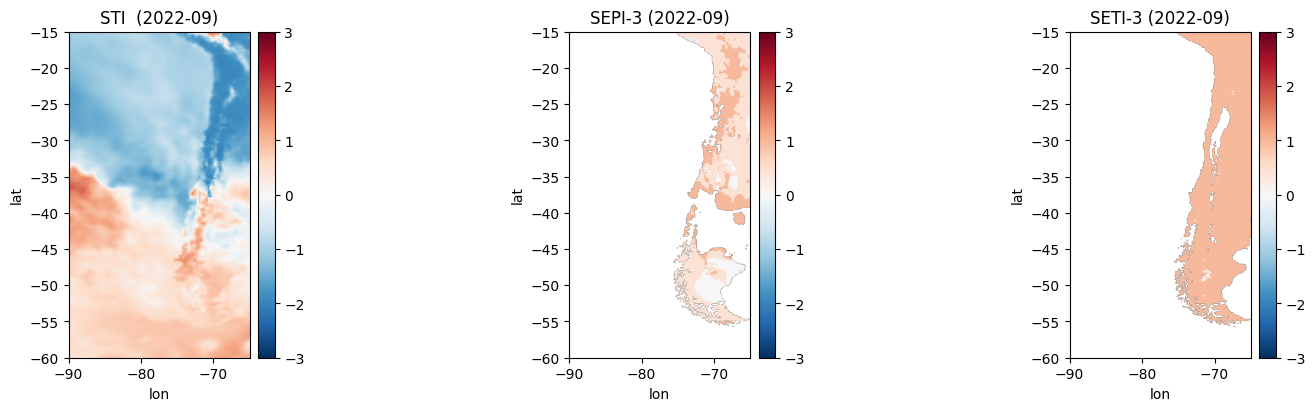

In [ ]:
sti_plot    = to_2d_month_slice(sti_month, MONTH_TARGET)
sepi3_plot  = to_2d_month_slice(sepi_ds["SEPI-3"], MONTH_TARGET)
seti3_plot  = to_2d_month_slice(seti_ds["SETI(PET)-3"], MONTH_TARGET)

fig, axs = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
imshow_map(axs[0], sti_plot,   f"STI  ({MONTH_TARGET})", 3.0)
imshow_map(axs[1], sepi3_plot, f"SEPI-3 ({MONTH_TARGET})", 3.0)
imshow_map(axs[2], seti3_plot, f"SETI-3 ({MONTH_TARGET})", 3.0)
plt.show()


## 8) Resumen numérico rápido (promedios ponderados por latitud)

Para benchmarks regionales sencillos.

In [ ]:
import numpy as np, pandas as pd, xarray as xr

def area_mean_weighted(da: xr.DataArray, month_target: str) -> float:
    """
    Devuelve el promedio espacial ponderado por cos(lat) para el mes month_target ('YYYY-MM').
    Acepta da con dims extra ('time', 'month'); devuelve siempre un escalar.
    """
    d = da

    # Selección por 'time' si existe
    if "time" in d.dims:
        try:
            d = d.sel(time=month_target)
        except Exception:
            # fallback si el index no es string mensual exacto
            t = pd.to_datetime(d.time.values).astype("datetime64[M]").astype(str)
            idx = np.where(t == month_target)[0]
            if idx.size == 0:
                raise ValueError(f"Mes {month_target} no está en 'time'")
            d = d.isel(time=int(idx[0]))

    # Selección por 'month' si quedó esa dim
    if "month" in d.dims:
        d = d.sel(month=int(month_target[-2:]))

    # Quita dims de tamaño 1 y asegúrate de 2D lat/lon
    d = d.squeeze(drop=True)
    if set(d.dims) != {"latitude","longitude"}:
        raise ValueError(f"Esperaba 2D (lat,lon); obtuve dims {d.dims} con shape {tuple(d.shape)}")

    # Peso cos(lat) (1D) y promedio ponderado
    w = xr.DataArray(np.cos(np.deg2rad(d.latitude.astype("float32"))),
                     dims=("latitude",))
    return float(d.weighted(w).mean(("latitude","longitude")).values)


In [ ]:
# ==== 8) Resumen espacial ponderado por cos(lat) ====
lat = sti_month["latitude"].values.astype("float32")
W   = np.cos(np.deg2rad(lat))[:,None].astype("float32")

print("Área-media (σ):")
print("  STI:         ", area_mean_weighted(sti_month, MONTH_TARGET))
# print("  SEPI-3:      ", area_mean_weighted(sepi_ds["SEPI-3"], MONTH_TARGET))
# print("  SETI(PET)-3: ", area_mean_weighted(seti_ds["SETI(PET)-3"], MONTH_TARGET))



Área-media (σ):
[########################################] | 100% Completed | 101.79 ms
  STI:          -0.41958773136138916


## 9) Exportables (NetCDF) para intercambio

Guarda un paquete con los índices del mes objetivo.

In [ ]:
# ==== 9) Exportar NetCDF ====
out_nc = f"indices_{MONTH_TARGET.replace('-','')}_chile.nc"
to_save = xr.Dataset({
    "STI": sti_month,
    **{k: sepi_ds[k] for k in sepi_ds.data_vars},
    **{k: seti_ds[k] for k in seti_ds.data_vars},
})
encoding = {vn: {"zlib": True, "complevel": 4, "dtype": "float32"} for vn in to_save.data_vars}
to_save.to_netcdf(out_nc, encoding=encoding)
print("Escrito:", out_nc)


[########################################] | 100% Completed | 101.35 ms
[                                        ] | 0% Completed | 192.99 us

/usr/local/lib/python3.12/dist-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


[########################################] | 100% Completed | 102.05 ms
[########################################] | 100% Completed | 102.43 ms
[########################################] | 100% Completed | 101.83 ms
[########################################] | 100% Completed | 102.39 ms
[########################################] | 100% Completed | 102.96 ms
[########################################] | 100% Completed | 102.35 ms
[########################################] | 100% Completed | 101.82 ms
[########################################] | 100% Completed | 101.79 ms
[########################################] | 100% Completed | 177.77 s
Escrito: indices_202209_chile.nc
